In [1]:
import numpy as np
import os
import cv2
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from patchify import patchify
from PIL import Image
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Making image generators from the patches for training and validation sets
seed = 24
batch = 10
img_data_arg = dict(rescale=1/255,horizontal_flip=True,vertical_flip = True)
msk_data_arg = dict(rescale=1/255,horizontal_flip=True,vertical_flip = True)

image_data_generator = ImageDataGenerator(**img_data_arg)
image_generator= image_data_generator.flow_from_directory(r"PATCH_DATA\train_images\\",
                                                          seed=seed,
                                                          batch_size = batch,
                                                          target_size = (256, 256),
                                                          class_mode = None)

mask_data_generator = ImageDataGenerator(**msk_data_arg)
mask_generator = mask_data_generator.flow_from_directory(r"PATCH_DATA\train_masks\\",
                                                         seed=seed,
                                                         batch_size = batch,
                                                         target_size=(256, 256),
                                                         color_mode = "grayscale",
                                                         class_mode = None)

valid_image_generator = image_data_generator.flow_from_directory(r"PATCH_DATA\val_images\\",
                                                                 seed=seed,
                                                                 batch_size = batch,
                                                                 target_size=(256, 256),
                                                                 class_mode = None)

valid_mask_generator =  mask_data_generator.flow_from_directory(r"PATCH_DATA\val_masks\\",
                                                                seed=seed,
                                                                batch_size = batch,
                                                                target_size=(256, 256),
                                                                color_mode = "grayscale",
                                                                class_mode = None)

train_generator = zip(image_generator,mask_generator)
valid_generator = zip(valid_image_generator,valid_mask_generator)

Found 57657 images belonging to 1 classes.
Found 57657 images belonging to 1 classes.
Found 7207 images belonging to 1 classes.
Found 7207 images belonging to 1 classes.


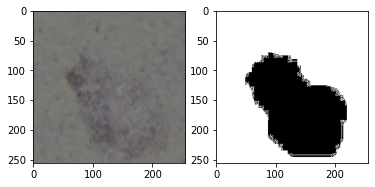

In [18]:
#Checking generators 
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [3]:
# Making the Unet model

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

checkpointer = tf.keras.callbacks.ModelCheckpoint ('model.h5', verbose = 1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs')]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [4]:
# batch processing for training the unet model
num_train_imgs = len(os.listdir(r"PATCH_DATA\train_images\train\\"))
steps_per_epoch = num_train_imgs//batch
history = model.fit_generator(train_generator, validation_data=valid_generator, steps_per_epoch = steps_per_epoch,
                              validation_steps=steps_per_epoch, epochs=20,callbacks=callbacks)

Epoch 1/20


C:\Users\shei972\AppData\Local\Temp\ipykernel_15260\3905202622.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=valid_generator, steps_per_epoch = steps_per_epoch,


5765/5765 [==============================] - 850s 146ms/step - loss: 0.6395 - accuracy: 0.6467 - val_loss: 0.6188 - val_accuracy: 0.6671
Epoch 2/20
5765/5765 [==============================] - 822s 142ms/step - loss: 0.5877 - accuracy: 0.6941 - val_loss: 0.4812 - val_accuracy: 0.7740
Epoch 3/20
5765/5765 [==============================] - 823s 143ms/step - loss: 0.4830 - accuracy: 0.7697 - val_loss: 0.4535 - val_accuracy: 0.7889
Epoch 4/20
5765/5765 [==============================] - 818s 142ms/step - loss: 0.4348 - accuracy: 0.8000 - val_loss: 0.3751 - val_accuracy: 0.8381
Epoch 5/20
5765/5765 [==============================] - 823s 143ms/step - loss: 0.3726 - accuracy: 0.8380 - val_loss: 0.3750 - val_accuracy: 0.8327
Epoch 6/20
5765/5765 [==============================] - 822s 143ms/step - loss: 0.3276 - accuracy: 0.8617 - val_loss: 0.3179 - val_accuracy: 0.8688
Epoch 7/20
5765/5765 [==============================] - 823s 143ms/step - loss: 0.3065 - accuracy: 0.8723 - val_loss: 0.304

In [5]:
# Saving the trained model
model.save('unet_Seagrass.hdf5')
# from keras.models import load_model
# model=load_model('unet_Seagrass.hdf5')

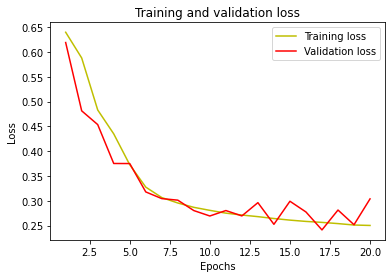

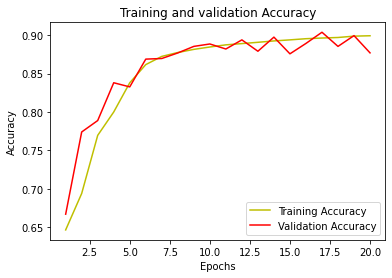

In [100]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Making image generator for the test set
image_data_generator = ImageDataGenerator(rescale=1/255)
mask_data_generator = ImageDataGenerator(rescale=1/255)

test_image_generator= image_data_generator.flow_from_directory(r"PATCH_DATA\test_images\\",
                                                          seed=seed,
                                                          batch_size = batch,
                                                          target_size = (256, 256),
                                                          class_mode = None)

test_mask_generator = mask_data_generator.flow_from_directory(r"PATCH_DATA\test_masks\\",
                                                         seed=seed,
                                                         batch_size = batch,
                                                         target_size=(256, 256),
                                                         color_mode = "grayscale",
                                                         class_mode = None)

Found 7208 images belonging to 1 classes.
Found 7208 images belonging to 1 classes.


1/1 [==============================] - 0s 172ms/step


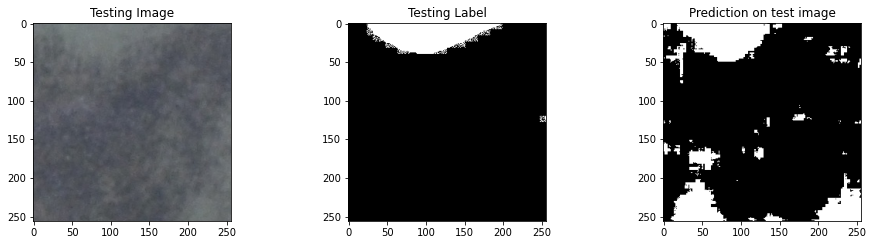

In [40]:
#testing test_generator and predicting on it
import random
from keras.models import load_model
model=load_model('unet_Seagrass.hdf5')

a = test_image_generator.next()
b = test_mask_generator.next()
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0]*255, cmap='gray', vmin=0,vmax=255)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction*255, cmap='gray', vmin=0,vmax=255)
plt.show()

In [ ]:
# For the accuracy of the model, check "Accuracy.ipynb"